In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

### Execute Multiple Simulations

This can be done using a bash script.

In [4]:
# execute bash script
!./script.sh

^C


### Parsing Output

At the end of our script's execution, we will have a directory called "data" which will contain end-states in several different sub-directories. Prior to visualization, we need to join all of these files into a single dataframe.

In [5]:
# Filter data for end-states only
# Collect all dead-end state files into a single dataframe
main_dir = 'data'
folders = os.listdir(main_dir)

files = [f'{main_dir}/{folder}/dead_ends.tsv' for folder in folders]

df = pd.read_csv(files[0], delimiter='\t')

for f in files[1:]:
    new_data = pd.read_csv(f, delimiter='\t')
    df = df.append(new_data)

df

,O2,H2O,H+,NO2-,NO3-,N2,NH4+,SO4-2,H2S,O2_INIT
0,8.363888e-67,55000000.0,0.02399,1.285703e-32,1.326299e-52,477.035074,2.102985e+01,28029.798695,2.020131e+01,50.000000
1,1.417013e-66,55000000.0,0.02399,1.338634e-32,1.406145e-52,479.556323,1.598735e+01,28031.356034,1.864397e+01,56.896552
2,1.670162e-66,55000000.0,0.02399,1.412413e-32,1.015666e-52,478.364323,1.837135e+01,28033.974172,1.602583e+01,60.344828
3,1.482260e-66,55000000.0,0.02399,1.430374e-32,1.555789e-52,480.540802,1.401840e+01,28034.065950,1.593405e+01,63.793103
4,1.760297e-66,55000000.0,0.02399,1.300815e-32,9.048377e-53,486.232627,2.634745e+00,28031.521219,1.847878e+01,67.241379
...,...,...,...,...,...,...,...,...,...,...
21,1.502381e+01,55000000.0,0.02399,1.633347e-13,3.730606e+00,485.684697,2.123414e-14,28050.000000,2.545509e-133,125.862069
22,4.236244e-26,55000000.0,0.02399,1.412055e+01,1.734054e+01,470.329995,2.978920e+00,28050.000000,4.736657e-87,136.206897
23,2.469760e-24,55000000.0,0.02399,3.439249e+00,2.599685e+01,471.768400,2.127101e+00,28050.000000,6.993528e-86,139.655172
24,1.592626e+01,55000000.0,0.02399,7.087143e-13,1.680175e+01,479.149125,9.640303e-14,28050.000000,2.243142e-133,143.103448


It is also important to note that not all simulations will reach a dead-end state - depending on what the parameters are, a simulation may run out of time before actually reaching completion. The rate of premature execution could be reduced significantly by playing around with the parameters in the `sim/config` directory.

Note that calculating the failure rate using the code below requires the existence of `report.txt` files, which are only generated when the simulation is executed in `--debug` mode. 

In [6]:
# Estimate premature execution rate from report.txt files
main_dir = 'data'
main_folders = os.listdir(main_dir)

total = 0
fails = 0

for main_folder in main_folders:
    folders = os.listdir(f'{main_dir}/{main_folder}')
    files = [f'{main_dir}/{main_folder}/{folder}/report.txt' for folder in folders if os.path.isdir(f'{main_dir}/{main_folder}/{folder}')]
    for fname in files:
        total += 1
        with open(fname) as f:
            content = f.read()
            if content == "success: False":
                fails += 1

print(f'Premature execution rate: {fails/total * 100:.2f}%')

Premature execution rate: 14.44%


### Generating Bifurcation Plots

Using our dataframe, we can visualize how our dead-end states vary with respect to some specific parameter that we specify. By running `./script.sh`, we have generated dead-end states for varying initial oxygen concentrations (between 50 and 100 $\mu M$). We can the relationship between final metabolite concentrations and initial oxygen concentration using a series of bifurcation plots.

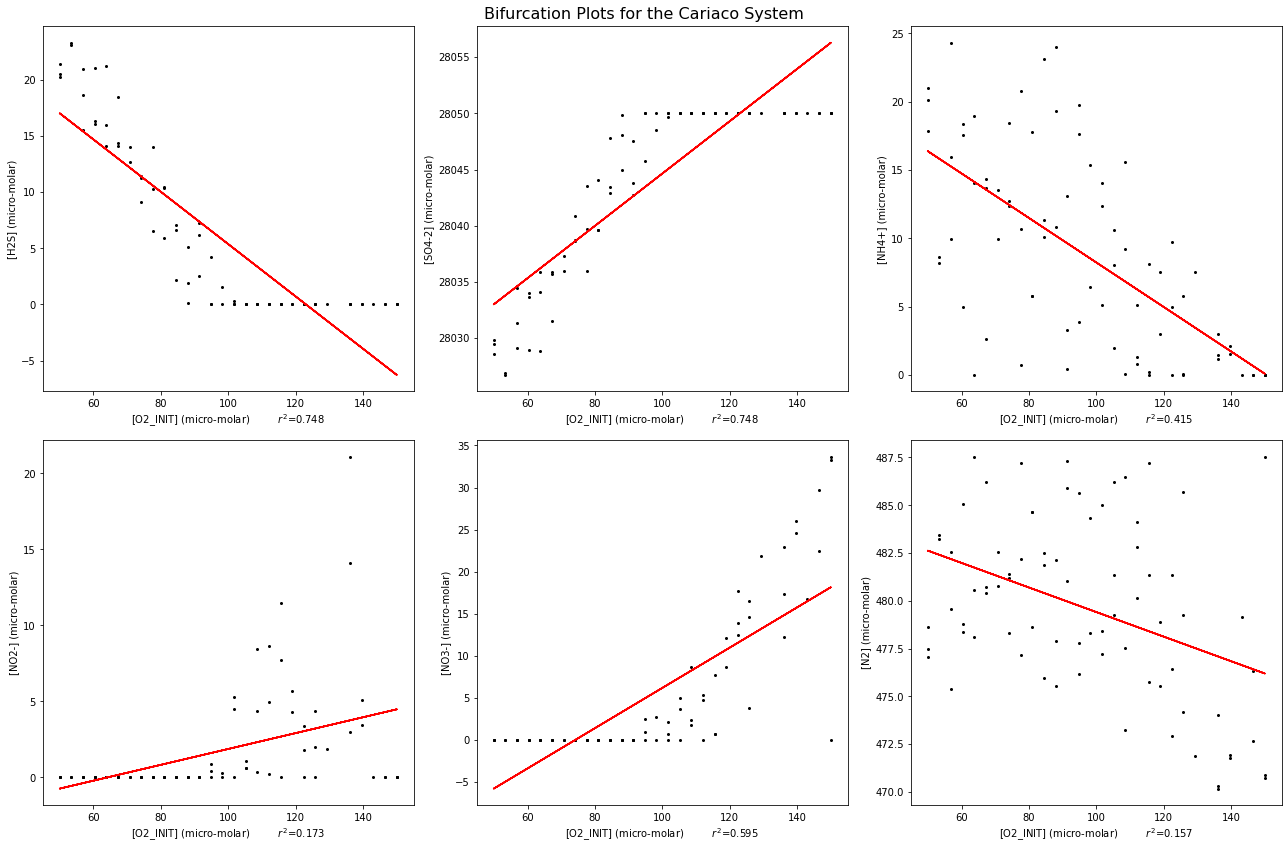

In [7]:
# For the Cariaco system, there are 6 metabolites we wish to visualize.

# Let's make 6 axes for 6 plots.
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(18, 12)
fig.suptitle('Bifurcation Plots for the Cariaco System', fontsize=16)

metabolite_list = ['H2S', 'SO4-2', 'NH4+', 'NO2-', 'NO3-', 'N2']
variable_of_interest = 'O2_INIT' # Important to add INIT to the end because that is the initial concentration, not the ending concentration.

x_data = df[variable_of_interest].to_numpy()

ax_list = axs.flatten()

for i in range(6):
    ax = ax_list[i]
    metabolite_of_interest = metabolite_list[i]

    y_data = df[metabolite_of_interest].to_numpy()

    # make a regression line - evaluate significance of correlation
    m, b = np.polyfit(x_data, y_data, 1)

    # determine r^2 value:
    yhat = m*x_data + b
    ybar = np.sum(y_data) / len(y_data)
    ssreg = np.sum((y_data - yhat) ** 2)
    sstot = np.sum((y_data - ybar) ** 2)

    r_squared = 1 - (ssreg / sstot)

    ax.set_xlabel(f'[{variable_of_interest}] (micro-molar)\t\t$r^2$={r_squared:.3f}')
    ax.set_ylabel(f'[{metabolite_of_interest}] (micro-molar)')
        
    ax.scatter(x_data, y_data, s=4, c='black')
    ax.plot(x_data, m*x_data + b, c='red')

plt.tight_layout()
plt.show()